In [1]:
from utils import *
from extract_feature_AE import *
from extract_feature_PCA import *

In [2]:
import numpy as np
np.random.seed(42)

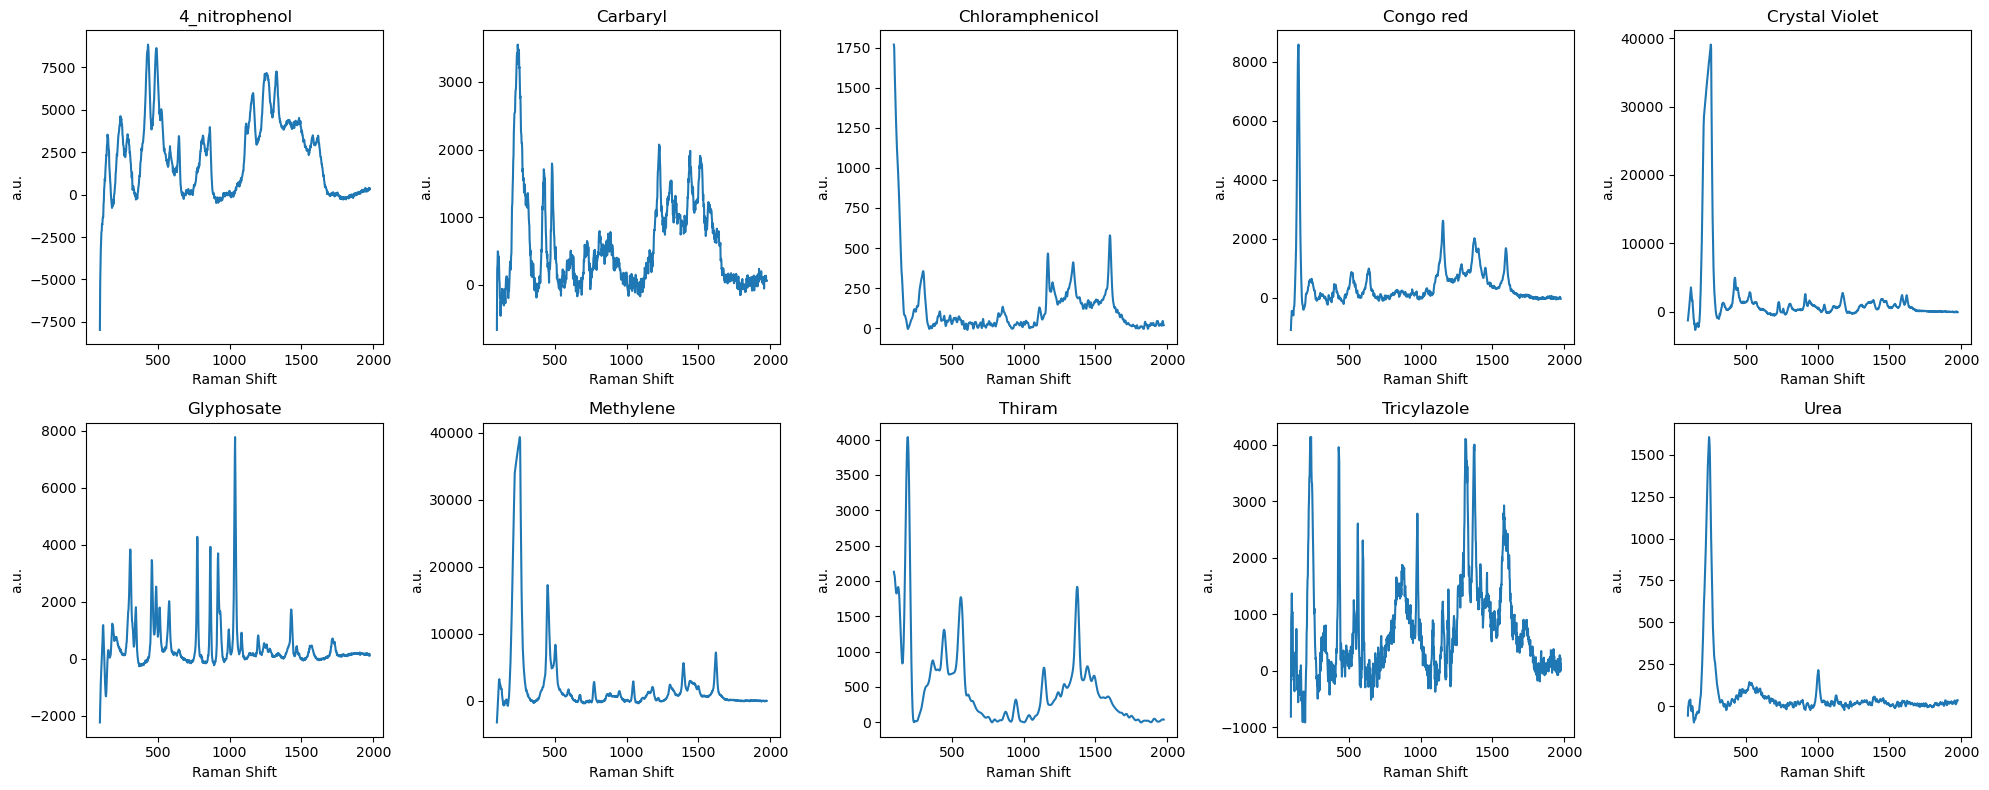

In [3]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

In [4]:
X, y = make_data(paths)
print(X.shape, y.shape)


(50, 2047) (50, 1)


In [5]:
def Norm(X, option = 'min_max'):
    if option == "min_max":
        X_min = X.min(axis=0, keepdims=True)
        X_max = X.max(axis=0, keepdims=True)
        X_norm = (X - X_min) / (X_max - X_min)
        return X_norm
    elif option == "z_score":
        X_mean = np.mean(X)
        X_std = np.std(X)
        Z_score = (X - X_mean) / X_std
        return Z_score


In [6]:
X= Norm(X)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)

In [8]:
y_test

array([[0.],
       [9.],
       [3.],
       [4.],
       [8.],
       [5.],
       [2.],
       [4.],
       [6.],
       [5.],
       [2.],
       [9.],
       [7.],
       [3.],
       [0.],
       [1.],
       [8.],
       [6.],
       [1.],
       [7.]])

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 2047) (30, 1) (20, 2047) (20, 1)


# Grid search

In [10]:
Grid_search_model(X_train,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l2', 'solver': 'liblinear'}, score: 0.90
Time taken for Logistic Regression: 8.60 seconds

Best parameters for SVM: {'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.80
Time taken for SVM: 1.36 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.87
Time taken for KNN: 9.24 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.57
Time taken for Decision Tree: 8.69 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}, score: 0.83
Time taken for Random Forest: 219.56 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.10
Time taken for Naive Bayes:

In [11]:
models = [LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear'),
          SVC(C = 1, degree = 2, gamma = 'scale', kernel = 'linear', shrinking = True,  probability=True),
          KNeighborsClassifier(algorithm = 'auto', metric = 'cosine', n_neighbors = 1, p = 1, weights = 'uniform'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'random',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [12]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    file_name = f"./model/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/LogisticRegression.pkl' already saved
Model './model/SVC.pkl' already saved
Model './model/KNeighborsClassifier.pkl' already saved
Model './model/DecisionTreeClassifier.pkl' already saved
Model './model/RandomForestClassifier.pkl' already saved
Model './model/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[3. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


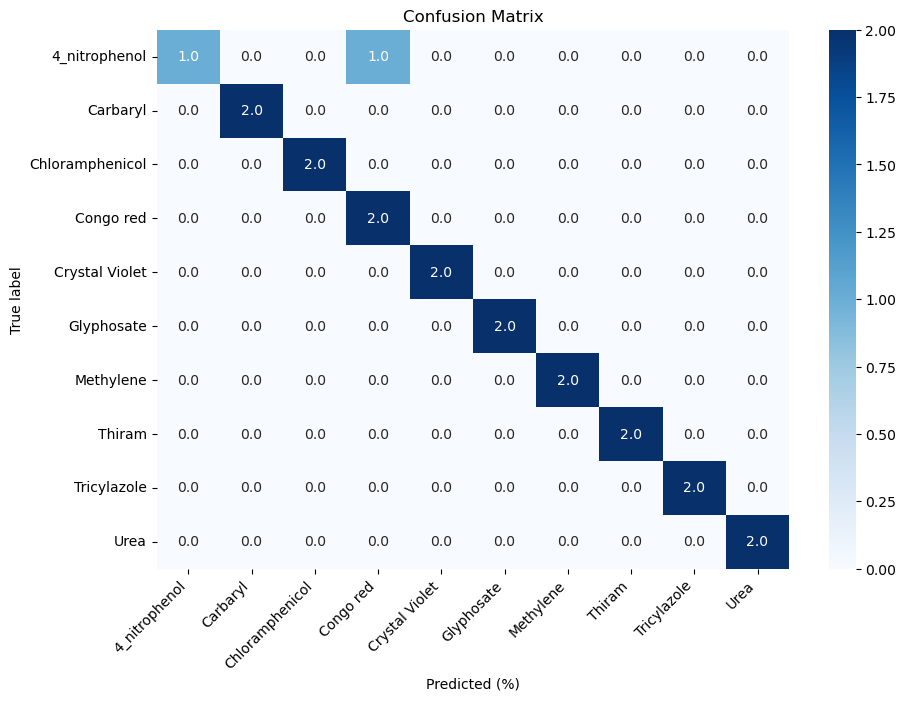

In [13]:
print(model_predict(X_test, y_test, models[0])['Predict'])
print(y_test.T)

# Ensemble

In [14]:
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svc', models[1]),
        ('random_forest', models[4]),
    ],
    voting='soft'
)

ensemble_clf.fit(X_train, y_train.ravel())



VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=10, solver='liblinear')),
                             ('svc',
                              SVC(C=1, degree=2, kernel='linear',
                                  probability=True)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=6,
                                                     random_state=42))],
                 voting='soft')

Testing with VotingClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[3. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


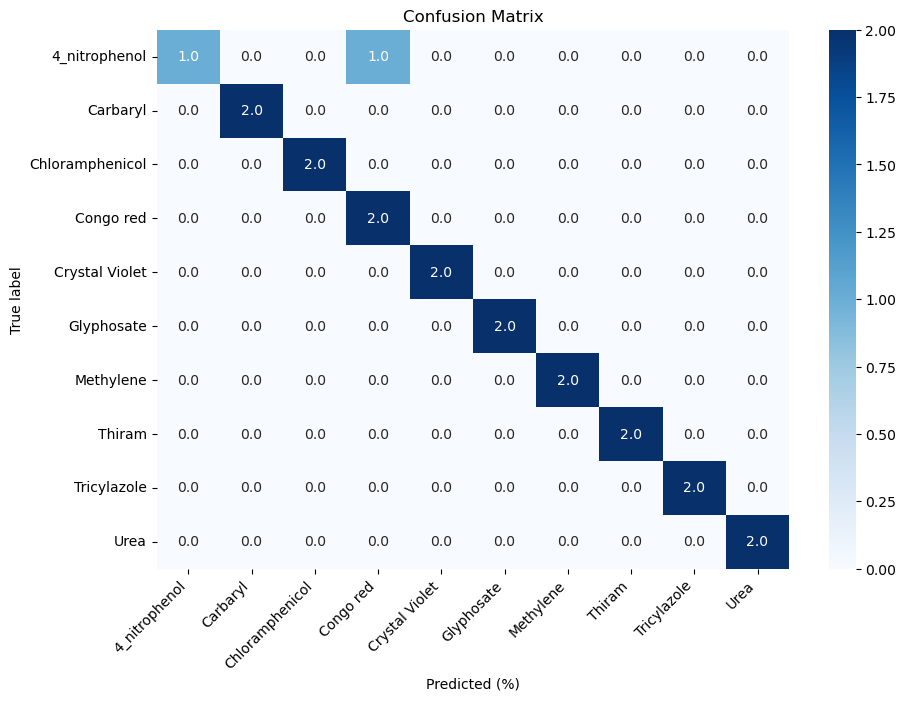

In [15]:
print(model_predict(X_test, y_test, ensemble_clf)['Predict'])
print(y_test.T)

In [16]:
proba = ensemble_clf.predict_proba(X_test)
proba[0]


array([0.12473529, 0.11794241, 0.12582025, 0.28115478, 0.03953012,
       0.03201181, 0.06337684, 0.086754  , 0.03518778, 0.09348672])

# Ensemble + Boosting

In [17]:
from sklearn.ensemble import AdaBoostClassifier
boosting_clf = AdaBoostClassifier(
    estimator=ensemble_clf,
    n_estimators=10,
    learning_rate=1.0
)
boosting_clf.fit(X_train, y_train.ravel())


AdaBoostClassifier(estimator=VotingClassifier(estimators=[('logistic',
                                                           LogisticRegression(C=10,
                                                                              solver='liblinear')),
                                                          ('svc',
                                                           SVC(C=1, degree=2,
                                                               kernel='linear',
                                                               probability=True)),
                                                          ('random_forest',
                                                           RandomForestClassifier(max_depth=6,
                                                                                  random_state=42))],
                                              voting='soft'),
                   n_estimators=10)

Testing with AdaBoostClassifier
Accuracy: 0.9000
Precision: 0.9167
Recall: 0.9000
F1-score: 0.8967
[3. 0. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


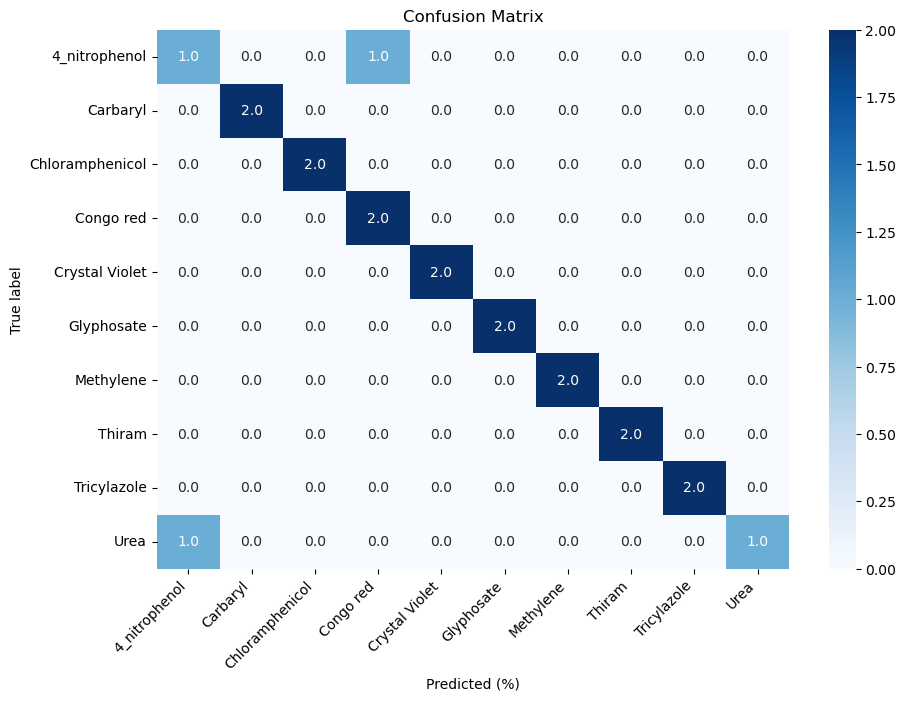

In [18]:
print(model_predict(X_test, y_test, boosting_clf)['Predict'])
print(y_test.T)

# Testing

Testing with LogisticRegression


<Axes: >

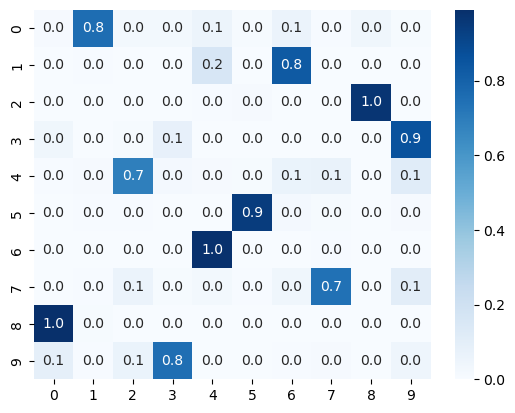

In [19]:
import numpy as np

def calculate_average_probabilities(model):
    result = model_predict(X_test, y_test, model, print_eval = False)
    labels = result["Class"]
    probabilities = result["Probability"]
    
    average_probabilities = []
    for label in set(labels):
        indices = [i for i, value in enumerate(labels) if value == label]
        label_probabilities = np.mean([probabilities[i] for i in indices], axis=0)
        average_probabilities.append(label_probabilities)
    
    return average_probabilities

# Sử dụng hàm calculate_average_probabilities
average_probabilities = calculate_average_probabilities(models[0])
# print(average_probabilities)
import seaborn as sn
sn.heatmap(average_probabilities, annot=True, fmt=".1f", cmap="Blues")

In [20]:
Trycilazole = ['test_Tricylazole/Tricyclazole-1.txt','test_Tricylazole/Tricyclazole-2.txt','test_Tricylazole/Tricyclazole-3.txt',
               'test_Tricylazole/Tricyclazole-4.txt','test_Tricylazole/Tricyclazole-5.txt']
for i in range(5):
    print(model_predict(X_test, y_test, models[i], path = Trycilazole[0])['Predict'])

Testing with LogisticRegression
[8.]
Testing with SVC
[8.]
Testing with KNeighborsClassifier
[5.]
Testing with DecisionTreeClassifier
[8.]
Testing with RandomForestClassifier
[5.]


In [21]:
for i in range(5):
    print(model_predict(X_test, y_test, models[i], path = Trycilazole[1])['Predict'])

Testing with LogisticRegression
[5.]
Testing with SVC
[8.]
Testing with KNeighborsClassifier
[5.]
Testing with DecisionTreeClassifier
[5.]
Testing with RandomForestClassifier
[5.]


In [22]:
for i in range(5):
    print(model_predict(X_test, y_test, models[i], path = Trycilazole[2])['Predict'])

Testing with LogisticRegression
[1.]
Testing with SVC
[1.]
Testing with KNeighborsClassifier
[1.]
Testing with DecisionTreeClassifier
[0.]
Testing with RandomForestClassifier
[1.]


In [23]:
for i in range(5):
    print(model_predict(X_test, y_test, models[i], path = Trycilazole[3])['Predict'])

Testing with LogisticRegression
[5.]
Testing with SVC
[8.]
Testing with KNeighborsClassifier
[5.]
Testing with DecisionTreeClassifier
[5.]
Testing with RandomForestClassifier
[5.]


In [24]:
for i in range(5):
    print(model_predict(X_test, y_test, models[i], path = Trycilazole[4])['Predict'])

Testing with LogisticRegression
[1.]
Testing with SVC
[8.]
Testing with KNeighborsClassifier
[1.]
Testing with DecisionTreeClassifier
[8.]
Testing with RandomForestClassifier
[5.]


Testing with LogisticRegression


<Axes: >

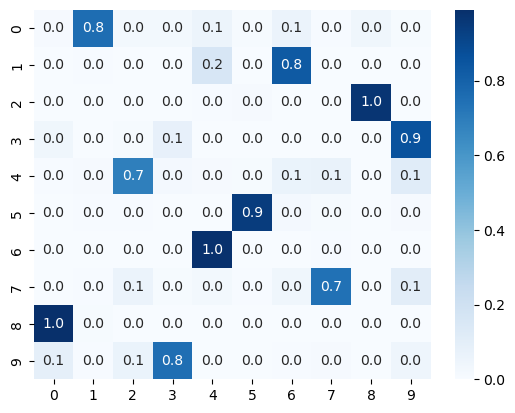

In [25]:
import numpy as np

def calculate_average_probabilities(model):
    result = model_predict(X_test, y_test, model, print_eval = False)
    labels = result["Class"]
    probabilities = result["Probability"]
    
    average_probabilities = []
    for label in set(labels):
        indices = [i for i, value in enumerate(labels) if value == label]
        label_probabilities = np.mean([probabilities[i] for i in indices], axis=0)
        average_probabilities.append(label_probabilities)
    
    return average_probabilities

# Sử dụng hàm calculate_average_probabilities
average_probabilities = calculate_average_probabilities(models[0])
# print(average_probabilities)
import seaborn as sn
sn.heatmap(average_probabilities, annot=True, fmt=".1f", cmap="Blues")

In [26]:
def plot_Tricylazole(paths, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= figsize)
    axes = axes.flatten()

    for i, path in enumerate(paths):
        data = pd.read_csv(path, sep="\t")

        x = data.iloc[-1000:, 0].values
        y = data.iloc[-1000:, 1].values
        ax = axes[i]
        ax.set_xlabel("Raman Shift")
        ax.set_ylabel("a.u.")
        ax.plot(x, y)

    
    plt.tight_layout()  
    plt.show()


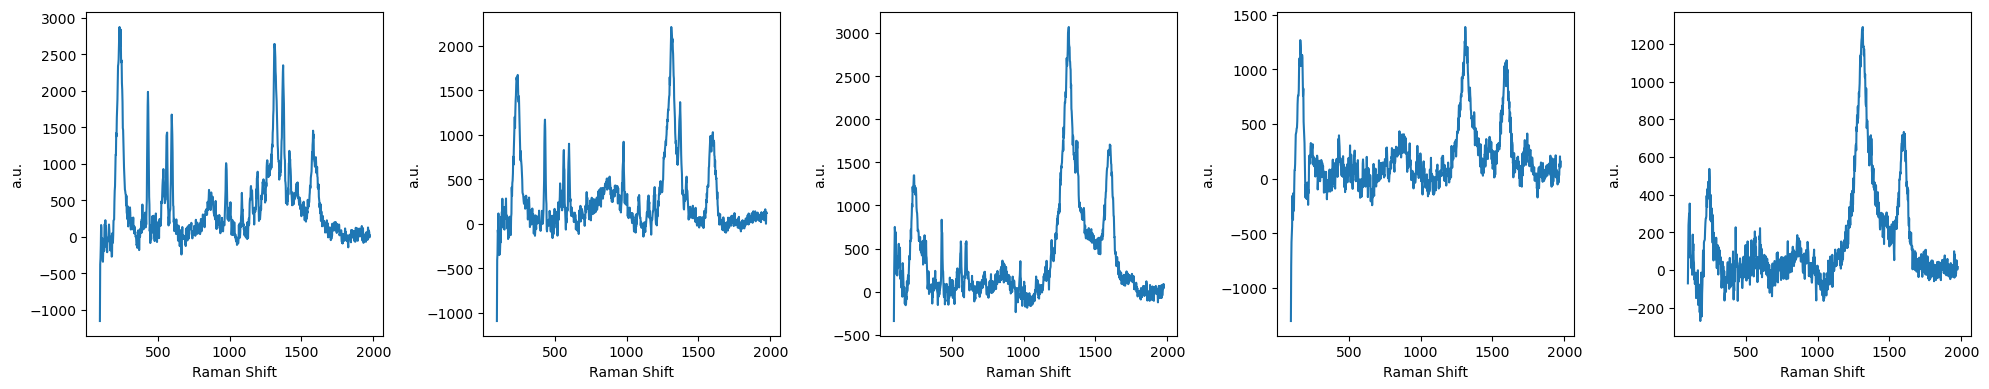

In [27]:
plot_Tricylazole(paths = Trycilazole, nrows=1, ncols=5, figsize = (20, 4))

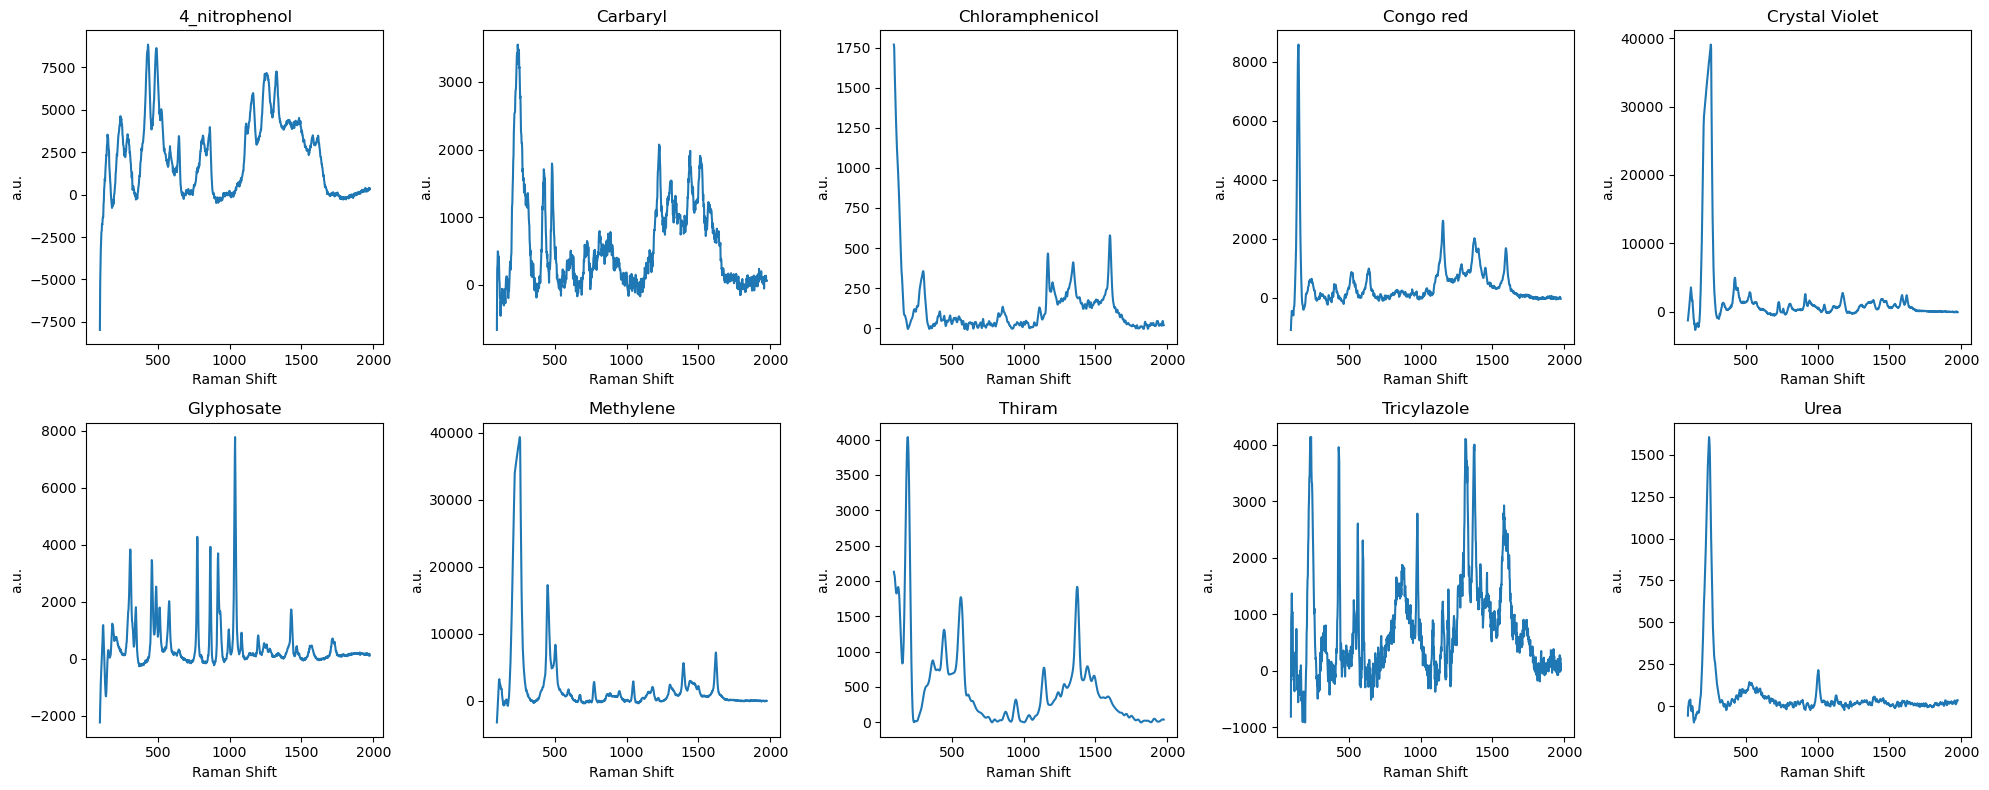

In [28]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

# Feature extraction PCA and training

In [29]:
X_mean = np.mean(X)
U = U_for_pca(X_train, X_mean, n_components = 3)
X_train_PCA = extract_PCA(X_train, X_mean, n_components=3)
# X_test_PCA = pca(X_test, X_mean, U)
X_test_PCA = extract_PCA(X_test, X_mean, n_components=3)

In [30]:
Grid_search_model(X_train_PCA,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.63
Time taken for Logistic Regression: 0.38 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.73
Time taken for SVM: 0.82 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.63
Time taken for KNN: 5.33 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.57
Time taken for Decision Tree: 1.38 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}, score: 0.53
Time taken for Random Forest: 190.00 seconds

Best parameters for Naive Bayes: {'alpha': 1.0}, score: 0.23
Time taken for Naive Bayes: 0.

In [31]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'gini', max_depth= 8, min_samples_leaf= 2, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [32]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/PCA/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/PCA/LogisticRegression.pkl' already saved
Model './model/PCA/SVC.pkl' already saved
Model './model/PCA/KNeighborsClassifier.pkl' already saved
Model './model/PCA/DecisionTreeClassifier.pkl' already saved
Model './model/PCA/RandomForestClassifier.pkl' already saved
Model './model/PCA/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
[5. 5. 5. 1. 5. 4. 7. 8. 0. 4. 7. 5. 2. 7. 5. 5. 5. 8. 7. 4.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


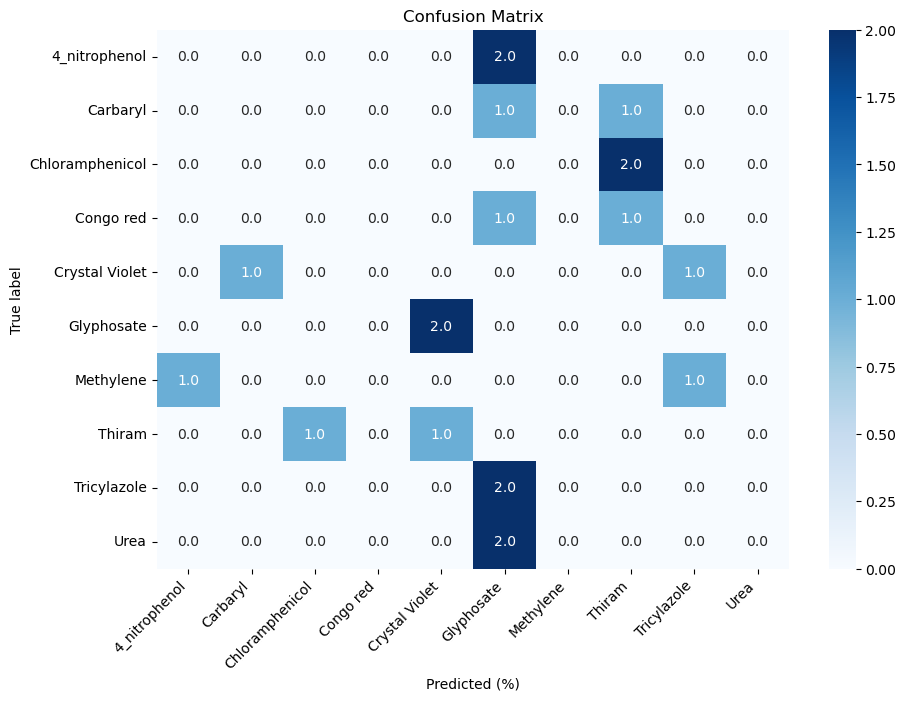

In [33]:
print(model_predict(X_test_PCA, y_test, models[0])['Predict'])
print(y_test.T)

# Feature extraction AutoEncoder and training

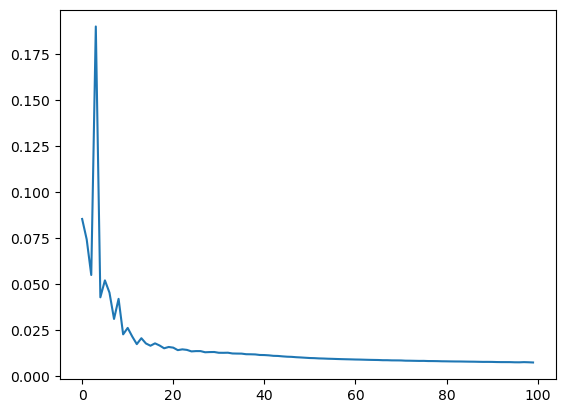

In [34]:
model = modelAE(X_train, out_features = 100, num_epochs = 100, learning_rate = 0.01)

In [35]:
X_train_AE = extractAE(model, X_train)
X_test_AE = extractAE(model, X_test)

In [36]:
Grid_search_model(X_train_AE,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}, score: 0.30
Time taken for Logistic Regression: 0.46 seconds

Best parameters for SVM: {'C': 0.01, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.23
Time taken for SVM: 0.83 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}, score: 0.23
Time taken for KNN: 7.22 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42, 'splitter': 'random'}, score: 0.23
Time taken for Decision Tree: 1.83 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.23
Time taken for Random Forest: 193.20 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.23
Time taken for Naive Baye

In [37]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [38]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_AE, y_train)
    file_name = f"./model/AutoEncoder/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)

Model './model/AutoEncoder/LogisticRegression.pkl' already saved
Model './model/AutoEncoder/SVC.pkl' already saved
Model './model/AutoEncoder/KNeighborsClassifier.pkl' already saved
Model './model/AutoEncoder/DecisionTreeClassifier.pkl' already saved
Model './model/AutoEncoder/RandomForestClassifier.pkl' already saved
Model './model/AutoEncoder/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.1000
Precision: 0.0833
Recall: 0.1000
F1-score: 0.0900
[2. 1. 2. 4. 4. 3. 9. 1. 6. 7. 9. 6. 3. 7. 5. 6. 5. 1. 7. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


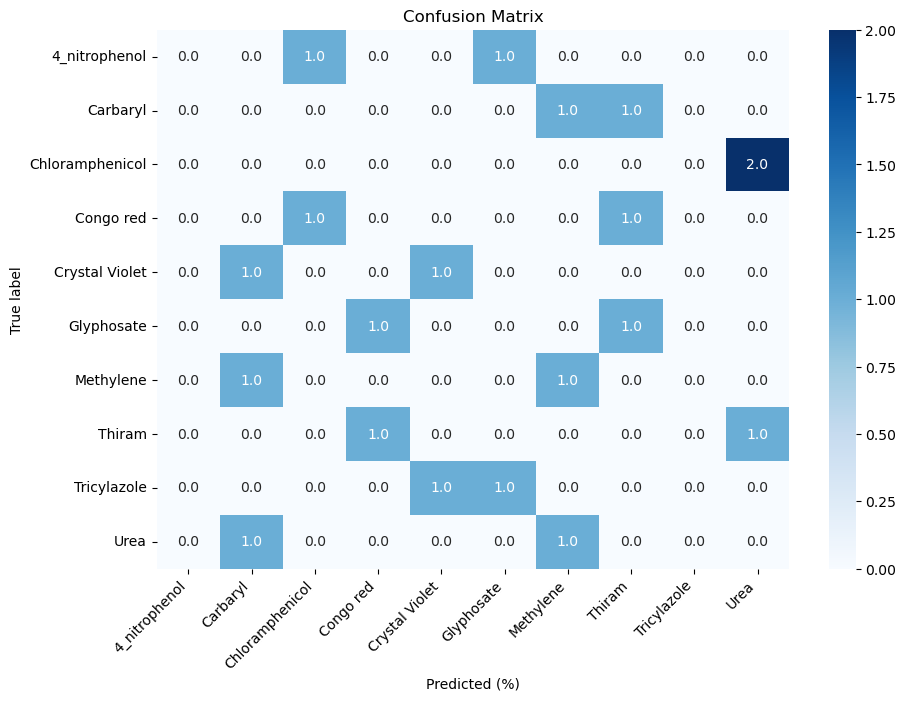

In [39]:
print(model_predict( X_test_AE, y_test, models[0])['Predict'])
print(y_test.T)

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)  

X_tsne = tsne.fit_transform(X)


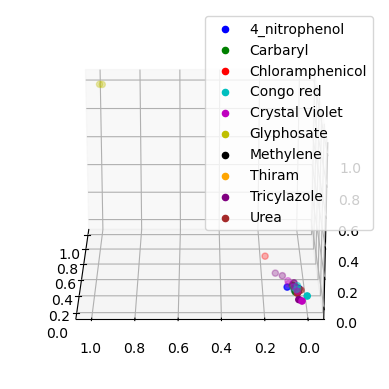

In [41]:
visualize(X,y, option = "3d",eval = 20, azim = 180, legend = True)